In [1]:
pip install openbb

  Using cached openbb-4.3.2-py3-none-any.whl.metadata (10 kB)
  Using cached openbb_benzinga-1.3.2-py3-none-any.whl.metadata (928 bytes)
  Using cached openbb_bls-1.0.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached openbb_cftc-1.0.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached openbb_commodity-1.2.2-py3-none-any.whl.metadata (950 bytes)
  Using cached openbb_core-1.3.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached openbb_crypto-1.3.2-py3-none-any.whl.metadata (942 bytes)
  Using cached openbb_currency-1.3.2-py3-none-any.whl.metadata (943 bytes)
  Using cached openbb_derivatives-1.3.2-py3-none-any.whl.metadata (907 bytes)
  Using cached openbb_econdb-1.2.2-py3-none-any.whl.metadata (1.0 kB)
  Using cached openbb_economy-1.3.2-py3-none-any.whl.metadata (948 bytes)
  Using cached openbb_equity-1.3.2-py3-none-any.whl.metadata (1.4 kB)
  Using cached openbb_etf-1.3.2-py3-none-any.whl.metadata (828 bytes)
  Using cached openbb_federal_reserve-1.3.2-py3-none-any.whl.metadata (980

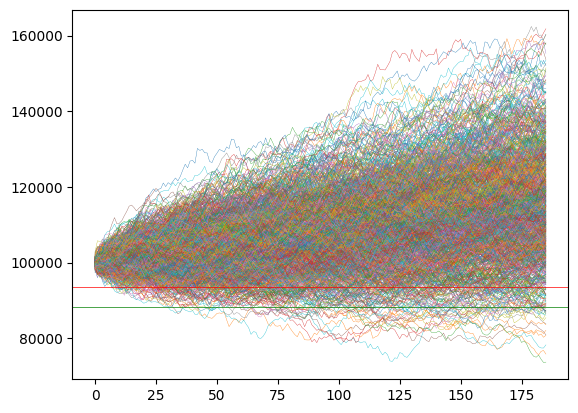

In [3]:
import numpy as np
import pandas as pd
from openbb import obb

sectors = [
    "XLE", 
    "XLF", 
    "XLU", 
    "XLI", 
    "GDX", 
    "XLK", 
    "XLV", 
    "XLY", 
    "XLP", 
    "XLB", 
    "XOP", 
    "IYR", 
    "XHB", 
    "ITB", 
    "VNQ", 
    "GDXJ", 
    "IYE", 
    "OIH", 
    "XME", 
    "XRT", 
    "SMH", 
    "IBB", 
    "KBE", 
    "KRE", 
    "XTL", 
]

data = obb.equity.price.historical(
    sectors, 
    start_date="2024-01-01", 
    provider="yfinance"
).to_df()

data["returns"] = data.groupby("symbol").close.pct_change()

portfolio_stats = data.groupby("symbol").agg(
    daily_returns=("returns", "mean"),
)

portfolio_stats["weights"] = 1 / len(sectors)

covariance_matrix = (
    data
    .pivot(
        columns="symbol", 
        values="returns"
    )
    .dropna()
    .cov()
)
simulations = 1_000
days = len(data.index.unique())
initial_capital = 100_000

portfolio = np.zeros((days, simulations))

historical_returns = np.full(
    shape=(days, len(sectors)), 
    fill_value=portfolio_stats.daily_returns
)

L = np.linalg.cholesky(covariance_matrix)

for i in range(0, simulations):
    Z = np.random.normal(size=(days, len(sectors)))
    daily_returns = historical_returns + np.dot(L, Z.T).T
    portfolio[:, i] = (
        np.cumprod(np.dot(daily_returns, portfolio_stats.weights) + 1) * initial_capital
    )

simulated_portfolio = pd.DataFrame(portfolio)

alpha = 5

def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)

def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()

mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)

ax = simulated_portfolio.plot(lw=0.25, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")